# 1. Visualizing the locations of all the stations

**Input data**

In [1]:
import numpy as np
import pandas as pd
from bq_helper import BigQueryHelper
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "My Project 44946-4bb12421de5a.json"

bq_assistant = BigQueryHelper(active_project= "bigquery-public-data", dataset_name= "noaa_gsod")

**Estimating how much memory the query need**

In [2]:
QUERY = """
        SELECT lat, lon
        FROM `bigquery-public-data.noaa_gsod.stations`
        """
bq_assistant.estimate_query_size(QUERY)

0.00042545050382614136

**Querying Data**

In [3]:
df = bq_assistant.query_to_pandas_safe(QUERY)
df.head()
#df.to_csv('noa_gsod_stations.csv')

,lat,lon
0,0.00,0.000
1,0.00,0.000
2,0.00,0.000
3,32.95,65.567
4,0.00,0.000


**Projecting the stations into map
**

[Detail of Basemap](https://matplotlib.org/basemap/api/basemap_api.html)

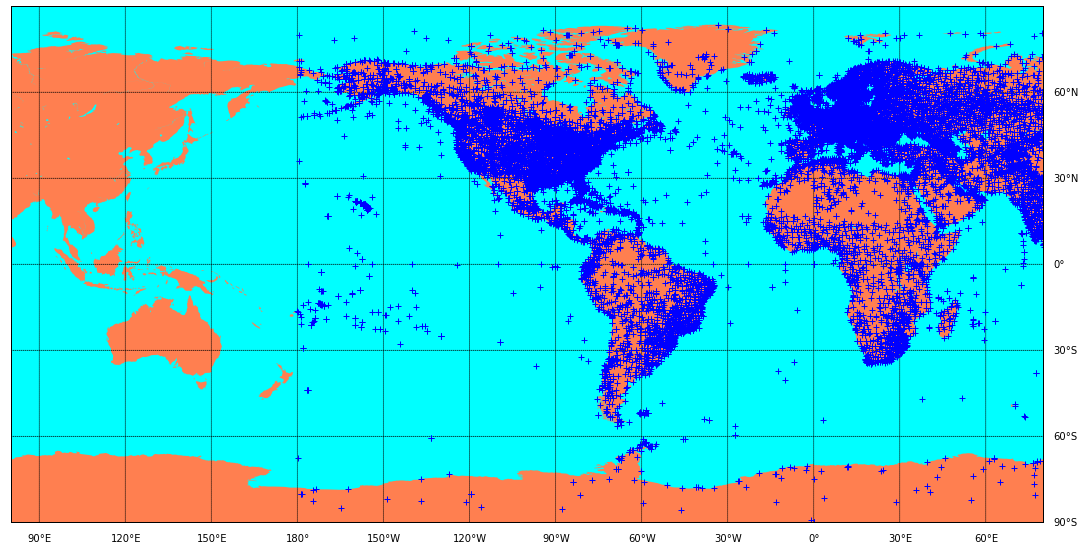

In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

m = Basemap(projection='cyl',lat_0=0, lon_0=-100, resolution='l', area_thresh=1000.0)
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral',lake_color='aqua')
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(0.,350.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True])
lon = df['lon'].tolist()
lat = df['lat'].tolist()
xpt,ypt = m(lon,lat)
m.plot(xpt,ypt,'b+') 
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

# 2. Visualizing Global Averaged Temperature in 2017

**Querying data**

In [5]:
QUERY = """
        SELECT stn, avg_temp, lat,lon
        FROM(
            SELECT stn,AVG(data.temp) AS avg_temp
            FROM `bigquery-public-data.noaa_gsod.gsod2017` AS data
            GROUP BY stn
        )temp_
        INNER JOIN `bigquery-public-data.noaa_gsod.stations`AS stations
        ON temp_.stn = stations.usaf
        
        """
bq_assistant.estimate_query_size(QUERY)

0.06462299823760986

**Data cleaning**

In [6]:
import time
t0 = time.time()
df = bq_assistant.query_to_pandas_safe(QUERY)
print(time.time()-t0)
print(df.head())
df['lat'].isnull().value_counts()

5.421471357345581
      stn   avg_temp     lat     lon
0  007026  74.773750   0.000   0.000
1  011430  40.547383  68.050  16.083
2  011930  30.485870  68.467  17.500
3  012240  47.299441  62.467   6.217
4  012780  44.268710  63.783  11.683


False    15369
True         2
Name: lat, dtype: int64

In [7]:
df = df.dropna(axis=0)
df.to_csv('noa_gsod_temp_2017.csv')
print('max_temp:%f'%df['avg_temp'].max())
print('min_temp:%f'%df['avg_temp'].min())

max_temp:100.400000
min_temp:-67.794722


**Visualization**

Here I only scatter the points with different colors that represent different temperature. If I have free time I will use interpolation to handle it.

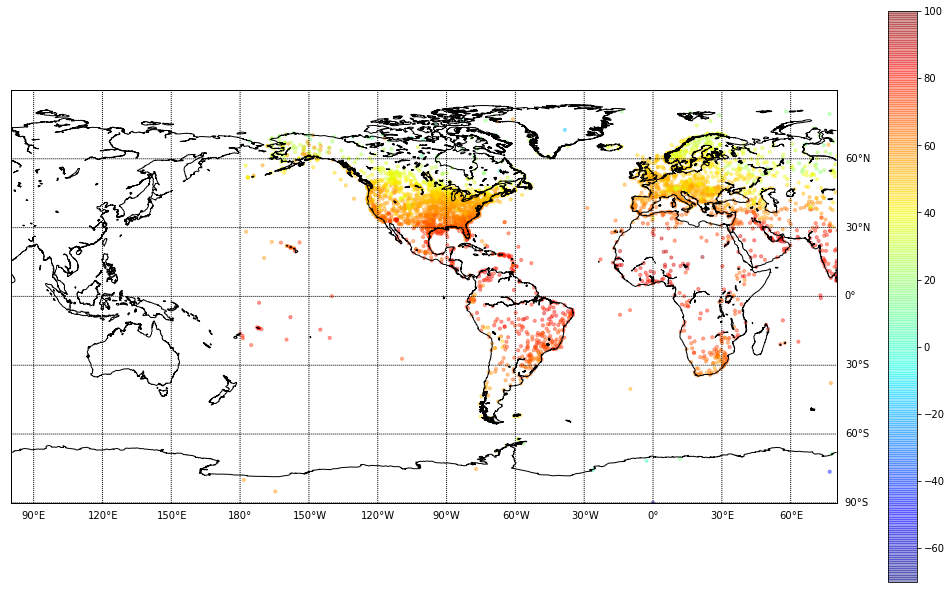

In [8]:
df_ = df.sample(5000)
m = Basemap(projection='cyl',lat_0=0, lon_0=-100, resolution='l', area_thresh=1000.0)
m.drawmapboundary()
m.drawcoastlines()
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(0.,350.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True])
lon = df_['lon'].tolist()
lat = df_['lat'].tolist()
df_['avg_temp'] = df_['avg_temp'].astype(int)
temp = df_['avg_temp'].tolist()
xpt,ypt = m(lon,lat)
cm = plt.cm.get_cmap('jet')
m.scatter(xpt, ypt, c=temp, cmap=cm, vmin = -70, vmax=100, s = 10, alpha = 0.4) 
plt.gcf().set_size_inches(18.5, 10.5)
plt.colorbar()
plt.show()

### Sample temp and precip at monthly average for multiple years

In [9]:
import time
t0 = time.time()
year_test_list = range(2020, 2021)
bq_assistant.max_wait_seconds = 3600
for year in year_test_list:
    query = '''
    SELECT stn, mo, avg_temp, avg_prcp, lat, lon
        FROM(
            SELECT stn, mo, AVG(data.temp) AS avg_temp, AVG(data.prcp) AS avg_prcp
            FROM `bigquery-public-data.noaa_gsod.gsod{0}` AS data
            GROUP BY stn, mo
        )temp_
        INNER JOIN `bigquery-public-data.noaa_gsod.stations`AS stations
        ON temp_.stn = stations.usaf
    '''.format(year)
    print(bq_assistant.estimate_query_size(query))
    qdata = bq_assistant.query_to_pandas_safe(query)
   # print(bq_assistant.max_wait_seconds)
    qdata.to_csv('noa_gsod_full_{0}.csv'.format(year))
    
print(time.time()-t0)

0.05286175385117531
10.7434663772583


**3. Plotting a dynamic picture of global temperature change**

Stay tuned